In [ ]:
!pip install --verbose git+https://github.com/mrzv/dionysus.git

In [2]:
import dionysus as dio
import numpy as np
import scipy.spatial as spatial
import cv2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

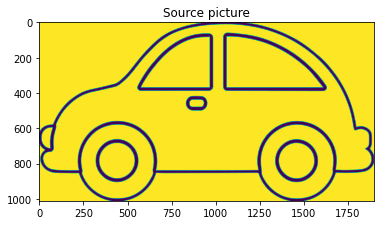

In [4]:
image = cv2.imread("./car.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.title("Source picture")
plt.imshow(image)
plt.show()

**Countours extraction**

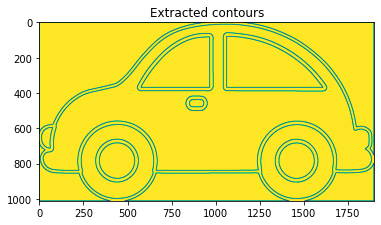

In [5]:
blur = cv2.GaussianBlur(image, (5, 5), 0)
retval, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_with_cont = cv2.drawContours(np.ones(image.shape), contours, -1, (0, 0, 255), 2, cv2.LINE_AA)

plt.title("Extracted contours")
plt.imshow(img_with_cont)
plt.show()

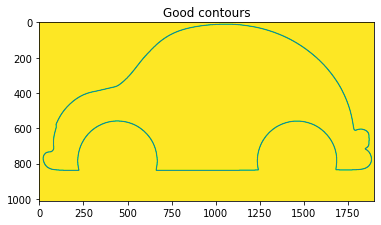

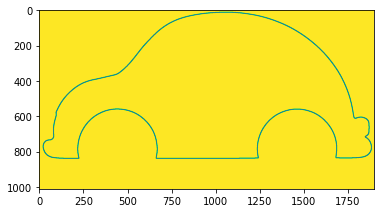

In [6]:
def is_contour_bad(cnt, img):
  if cv2.contourArea(cnt) < img.shape[0] * img.shape[1] * 0.15:
    return True
  if cv2.contourArea(cnt) > img.shape[0] * img.shape[1] * 0.5:
    return True

good_contours = []
for cnt in contours:
  if not is_contour_bad(cnt, image):
    good_contours.append(cnt)
  
img_with_cont = cv2.drawContours(np.ones(image.shape), good_contours, -1, (0, 0, 255), 2, cv2.LINE_AA)

plt.title("Good contours")
plt.imshow(img_with_cont)
plt.show()

for i in range(len(good_contours)):
  plt.imshow(cv2.drawContours(np.ones(image.shape), good_contours, -i, (0, 0, 255), 2, cv2.LINE_AA))
  plt.show()

In [7]:
def plot_with_points(img, points, title="Picture with points"):
  img = img.copy()

  blue = [0, 0, 255]

  for x, y in points:
    img = cv2.circle(img, (y, x), 10, blue, -1)

  plt.title(title)
  plt.imshow(img)
  plt.show()

First 5 points:  [(876, 1825), (101, 24), (707, 1282), (717, 1445), (1002, 786)]


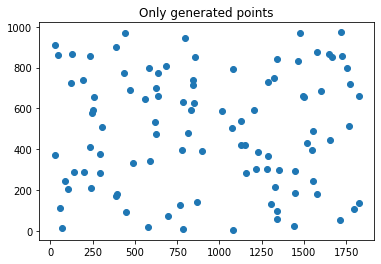

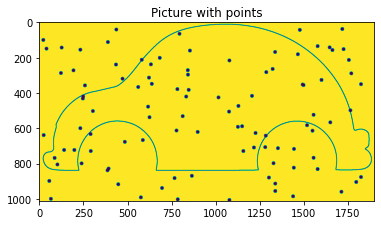

In [8]:
num_points = 100

x = np.random.randint(0, img_with_cont.shape[0], num_points)
y = np.random.randint(0, img_with_cont.shape[1], num_points)
points = list(zip(x, y))

#print(img_with_cont.shape)
#print(x)
#print(y)
print("First 5 points: ", points[:5])
plt.title("Only generated points")
plt.scatter(y, img_with_cont.shape[0] - x)
plt.show()

plot_with_points(img_with_cont, points)

**Keep points that are only inside a contour**

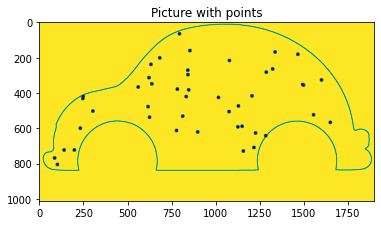

In [9]:
points = list(filter(lambda p: cv2.pointPolygonTest(good_contours[0], (p[1], p[0]), False) == 1, points))

plot_with_points(img_with_cont, points)

**Create circles around points**

In [10]:
def plot_with_circles(img, points, radius, title="Picture with circles"):
  img = img.copy()

  red  = [0, 0, 10]
  blue = [0, 0, 255]

  for x, y in points:
    img = cv2.circle(img, (y, x), 7, blue, -1)
    img = cv2.circle(img, (y, x), radius, red, 2)

  plt.title(title)
  plt.imshow(img)
  plt.show()

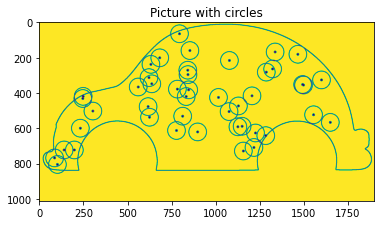

In [11]:
radius = 50

plot_with_circles(img_with_cont, points, radius)

**Let's find indices of intersection circle centers for every point that we have.**

Neighbors - coordindates of points, whose circles intersect with a given point.

In [12]:
point_tree = spatial.cKDTree(points)

neighbors_indices = []
for x, y in points:
  neighbors_indices.append(point_tree.query_ball_point([x, y], 2 * radius))

neighbors = []
for neigh in neighbors_indices:
  neighbors.append([points[n] for n in neigh])

print("Points: ", points[:10])
print("Neighbor indices: ", neighbors_indices[:10])
print("Neighbor points: ", neighbors[:10])

dict_points = dict()
for idx, coords in enumerate(points):
  dict_points[idx] = { "coords": coords, "neighbors_idx": neighbors_indices[idx], "neighbors_coords": neighbors[idx], "x": coords[0], "y": coords[1] }

Points:  [(723, 200), (432, 248), (161, 855), (349, 639), (283, 1288), (642, 1285), (426, 1017), (768, 88), (627, 1227), (478, 618)]
Neighbor indices:  [[0, 24], [16, 20, 1], [2], [12, 15, 3], [4, 28], [17, 8, 5], [6, 36], [7, 11, 24], [23, 17, 8, 5], [9, 19]]
Neighbor points:  [[(723, 200), (723, 142)], [(503, 305), (420, 250), (432, 248)], [(161, 855)], [(367, 562), (314, 623), (349, 639)], [(283, 1288), (265, 1324)], [(709, 1218), (627, 1227), (642, 1285)], [(426, 1017), (506, 1077)], [(768, 88), (805, 104), (723, 142)], [(589, 1151), (709, 1218), (627, 1227), (642, 1285)], [(478, 618), (538, 626)]]


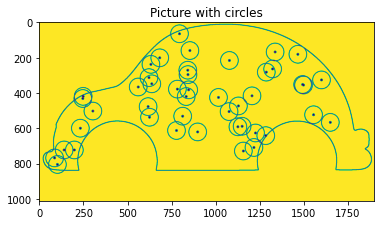

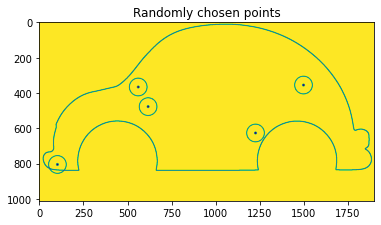

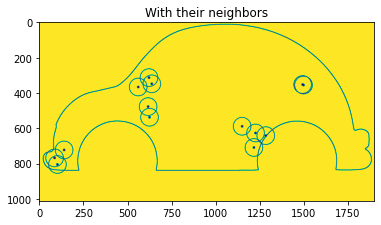

In [20]:
# randomly choose 5 points and check if it has all valid neighbors.

start = np.random.randint(len(points) - 6)
end = start + 5

chosen_randomly = points[start:end]
with_neighbors  = chosen_randomly.copy()

for neighs in neighbors[start:end]:
  with_neighbors += neighs

plot_with_circles(img_with_cont, points, radius)
plot_with_circles(img_with_cont, chosen_randomly, radius, title="Randomly chosen points")
plot_with_circles(img_with_cont, with_neighbors, radius, title="With their neighbors")
